In [1]:
import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from silx.io.specfile import SpecFile,Scan
import hdf5plugin
import fabio
from matplotlib import gridspec
import ipywidgets as widgets
from ipywidgets import interact
# %matplotlib ipympl


In [ ]:
# Nd = xu.materials.elements.Nd
# Ni = xu.materials.elements.Ni
# O = xu.materials.elements.O

# NNO = xu.materials.Crystal(
#     "NNO", xu.materials.SGLattice(123, 3.905, 3.30, atoms=[Nd, Ni,O],
#                                   pos=['1d', '1a','2f']))

In [ ]:
# # plt.figure()
# NNO.show_unitcell()
# plt.show()

# checking scans

In [2]:
scan_num = 2

# ============ load img file ====================

# base_path = r'D:\Stanford\My Drive\temp\202308_SSRL_XRD_nickelate\data\NNO_STO'
base_path = r'/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO'
scan_dir = 'find_ubr'
file_name = scan_dir+'_scan'+str(scan_num).zfill(3) +'_master.h5'

imgs = np.array(fabio.open(base_path+'/'+scan_dir+'/images/'+file_name).dataset[0]).astype(float)
imgs[imgs > 1e8] = np.nan

# ============ load spec file ====================
# sf = SpecFile(r"D:\Stanford\My Drive\temp\202308_SSRL_XRD_nickelate\data\NNO_STO\cdw_mesh\cdw_mesh")
sf = SpecFile(base_path+ "/"  + scan_dir + "/" +scan_dir )
scan = sf[scan_num-1]
print('scan number: ' + str(scan.number) + ', length: ' + str(np.shape(scan.data)[1]))

for line in scan.header:
    if line[:3] == '#G3':
        UB = np.array(line.split(' ')[-9:]).astype(float).reshape([3,3])
    if line[:3] == '#P0':
        angles = np.array(line.split(' ')[1:-2]).astype(float)
    if line[:4] == '#P14':
        energy = np.array(line.split(' ')[4]).astype(float)

try:
    tt = scan.data_column_by_name('del')
except:
    tt = angles[0] * np.ones(np.shape(scan.data)[1])
    
try:
    eta = scan.data_column_by_name('eta')
except:
    eta = angles[1] * np.ones(np.shape(scan.data)[1])

try:
    chi = scan.data_column_by_name('chi')
except:
    chi = angles[2] * np.ones(np.shape(scan.data)[1])
    
try:
    phi = scan.data_column_by_name('phi')
except:
    phi = angles[3] * np.ones(np.shape(scan.data)[1])
    


scan number: 2, length: 31


In [3]:
qconversion = xu.QConversion(sampleAxis = ['z-','y+','z-'], detectorAxis = ['z-'], r_i = [0,1,0])

hxrd = xu.HXRD( [0,1,0], [0,0,1], en = energy, qconv =  qconversion)

hxrd.Ang2Q.init_area(
        'z+', 'x+',
        cch1=533, cch2=515,
        Nch1=1065, Nch2=1030,
        pwidth1=0.075, pwidth2=0.075,
        distance=540
    )

In [4]:
angle_values =   [eta, chi, phi, tt]   #[[26.056],  [13.028]]
qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

[array([-0.00443866, -0.0044394 , -0.00444014, -0.00444088, -0.00444161,
       -0.00444235, -0.00444307, -0.0044438 , -0.00444453, -0.00444526,
       -0.00444598, -0.00444671, -0.00444743, -0.00444815, -0.00444887,
       -0.00444959, -0.0044503 , -0.00445102, -0.00445173, -0.00445244,
       -0.00445315, -0.00445386, -0.00445456, -0.00445528, -0.00445598,
       -0.00445668, -0.00445738, -0.00445808, -0.00445877, -0.00445948,
       -0.00446017])] [array([-0.0004336 , -0.00043345, -0.00043331, -0.00043317, -0.00043302,
       -0.00043288, -0.00043273, -0.00043259, -0.00043244, -0.0004323 ,
       -0.00043216, -0.00043201, -0.00043187, -0.00043172, -0.00043158,
       -0.00043143, -0.00043129, -0.00043114, -0.000431  , -0.00043085,
       -0.00043071, -0.00043057, -0.00043042, -0.00043028, -0.00043013,
       -0.00042999, -0.00042984, -0.0004297 , -0.00042955, -0.00042941,
       -0.00042926])] [array([-0.00105518, -0.00105304, -0.00105085, -0.00104869, -0.00104647,
       -0.0010443

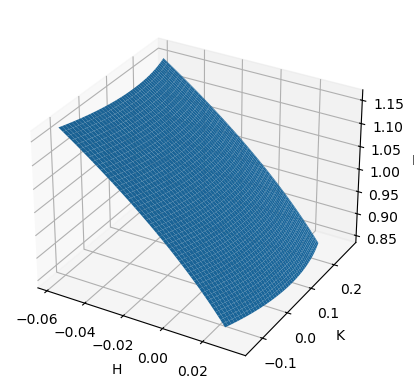

In [5]:
idx = 15
print([np.nanmean(qx, axis = (1,2)) -scan.data_column_by_name('H')], 
      [np.nanmean(qy, axis = (1,2)) -scan.data_column_by_name('K')], 
      [np.nanmean(qz, axis = (1,2)) -scan.data_column_by_name('L')])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(qx[idx],qy[idx],qz[idx])
ax.set_xlabel('H')
ax.set_ylabel('K')
ax.set_zlabel('L')

plt.show()

In [6]:
h_min,h_max = [np.min(qx), np.max(qx)]
k_min,k_max = [np.min(qy), np.max(qy)]
l_min,l_max = [np.min(qz), np.max(qz)]

h_n, k_n, l_n = [50, 50, 50]

gridder = xu.Gridder3D(nx=h_n, ny=k_n, nz=l_n)
gridder.KeepData(True)
gridder.dataRange(
    xmin=h_min, xmax=h_max,
    ymin=k_min, ymax=k_max,
    zmin=l_min, zmax=l_max,
    fixed=True
)

gridder(qx, qy, qz, imgs)

grid_data = gridder.data

coords = np.array([gridder.xaxis, gridder.yaxis, gridder.zaxis])


In [7]:
intensity = grid_data
xlen, ylen, zlen = np.shape(intensity)
cmap = plt.cm.viridis(intensity)
x,y,z = coords

fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(3, 3)

def plot_hyperspectral_data(x_section,y_section,z_section):
    vmin, vmax = np.nanpercentile(imgs, [20,95])
    x_slice = intensity[x_section, :, :]
    y_slice = intensity[:, y_section, :]
    z_slice = intensity[:, :, z_section]
    
    ax1 = plt.subplot(gs[0,2],aspect=1.0)
    ax1.pcolor(*np.meshgrid(y,z), x_slice, cmap='viridis', vmin = vmin, vmax = vmax)
    ax1.set_xlabel('K')
    ax1.set_ylabel('L')
    ax1.set_title(f'H = {x[x_section]:.3f}')
    ax1.set_aspect('equal')
    
    ax2 = plt.subplot(gs[1,2],aspect=1.0)
    ax2.pcolor(*np.meshgrid(x,z), y_slice, cmap='viridis', vmin = vmin, vmax = vmax)
    ax2.set_xlabel('H')
    ax2.set_ylabel('L')
    ax2.set_title(f'K = {y[y_section]:.3f}')
    ax2.set_aspect('equal')    
    
    ax3 = plt.subplot(gs[2,2],aspect=1.0)
    ax3.pcolor(*np.meshgrid(x,y), z_slice, cmap='viridis', vmin = vmin, vmax = vmax)
    ax3.set_xlabel('H')
    ax3.set_ylabel('K')
    ax3.set_title(f'L = {z[z_section]:.3f}')
    ax3.set_aspect('equal')

    ax = plt.subplot(gs[0:3,0:2], projection='3d', aspect = 'equal')
    xx, zz = np.meshgrid(x,z)
    ax.plot_surface(*np.meshgrid(x,y), np.ones_like(zz) * z[z_section], 
                    facecolors = cmap[:, :, z_section], alpha = 0.5, linewidth=0, vmin = vmin, vmax = vmax)
    ax.plot_surface(np.ones_like(xx) * x[x_section], *np.meshgrid(y,z), 
                    facecolors = cmap[x_section, :, :], alpha = 0.5, linewidth=0, vmin = vmin, vmax = vmax)
    ax.plot_surface(xx, np.ones_like(zz) * y[y_section], zz, 
                    facecolors = cmap[:, y_section, :], alpha = 0.5, linewidth=0, vmin = vmin, vmax = vmax)
    
    ax.set_xlabel('H')
    ax.set_ylabel('K')
    ax.set_zlabel('L')
    ax.set_title('Reciprocal space')
    plt.tight_layout()
    plt.show()
    
x_slider = widgets.IntSlider(min=0, max=xlen-1, step=1, value=28, description='H Section:')
y_slider = widgets.IntSlider(min=0, max=ylen-1, step=1, value=27, description='K Section:')
z_slider = widgets.IntSlider(min=0, max=zlen-1, step=1, value=26, description='L Section:')

interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider)

plt.show()


<Figure size 600x500 with 0 Axes>

interactive(children=(IntSlider(value=28, description='H Section:', max=49), IntSlider(value=27, description='…